In [9]:
import math, itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib_inline
import numpy as np

%matplotlib notebook
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# set constants
MU_0 = 4 * math.pi * 1e-7   # vaccuum permeability [H/m]
M_0 = 870_000               # coercivity [A/m]
X_B = 50 * 1e-3 / 2       # half-width [m], 49.5 mm
Y_B = 50 * 1e-3 / 2      # magnetisation half-length [m], 3.003 mm
Z_B = 50 * 1e-3 / 2     # half-thickness [m], 19.954 mm

In [10]:
def magnetic_field_intensity(x: float, y: float, z: float) -> tuple[float, float, float]:
    '''
    Inputs:
    `x, y, z`: position vector, relative to (0, 0, 0) as the geometric centre of the magnet, at which
    to calculate the magnetic flux density vector. Units: metre

    Outputs:
    `(B_x, B_y, B_z)`: B-field vector attached to input point. Units: Tesla

    Returns the magnetic field intensity vector (H_x, H_y, H_z) at a given point (x, y, z).
    Calculates for a cuboid-shaped bar magnet with its geometric centre at (0, 0, 0).
    The North and South poles are along the positive and negative y-axes respectively.

    Equation source: https://aip.scitation.org/doi/full/10.1063/1.1883308; page 2; eq. 5-7.
    '''

    scale_factor = M_0 / (4 * np.pi)
    sum_x = sum_y = sum_z = 0
     
    try:
        for (k, l, m) in itertools.product((1, 2), repeat = 3):
            # substitutions
            t = (-1)**(k + l + m)
            h_x = x + (-1)**k * X_B
            h_y = y + (-1)**l * Y_B
            h_z = z + (-1)**m * Z_B
            s = np.sqrt(h_x**2 + h_y**2 + h_z**2)
            # calculate summation expressions
            sum_x += t * np.log(h_z + s)
            sum_y += t * (h_x * h_y / (abs(h_x) * abs(h_y))) * np.arctan((abs(h_x) / abs(h_y)) * (h_z / s))
            sum_z += t * np.log(h_x + s)
    except ZeroDivisionError:
        raise ZeroDivisionError('The magnetic flux density on the boundary of the magnet is discontinuous.'
            f'The point ({x}, {y}, {z}) cannot be evaluated.')
    else:
        H_x = scale_factor * sum_x
        H_y = -1 * scale_factor * sum_y
        H_z = scale_factor * sum_z
    
    return (H_x, H_y, H_z)


def draw_cuboid(pos=(0, 0, 0), size=(1, 1, 1), ax=None, **kwargs):
    if ax is not None:
        l, w, h = size
        o = pos
        x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]], [o[0], o[0] + l, o[0] + l, o[0], o[0]],
            [o[0], o[0] + l, o[0] + l, o[0], o[0]], [o[0], o[0] + l, o[0] + l, o[0], o[0]]]
        y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]], [o[1], o[1], o[1] + w, o[1] + w, o[1]],
            [o[1], o[1], o[1], o[1], o[1]], [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]
        z = [[o[2], o[2], o[2], o[2], o[2]], [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],
            [o[2], o[2], o[2] + h, o[2] + h, o[2]], [o[2], o[2], o[2] + h, o[2] + h, o[2]]]
        x, y, z = np.array(x), np.array(y), np.array(z)
        ax.plot_surface(x, y, z, rstride=1, cstride=1, **kwargs)


def draw_magnet(ax=None):
    if ax.name == '3d':
        positions = [(-X_B, -Y_B, -Z_B), (-X_B, 0, -Z_B)]
        sizes = [(2 * X_B, Y_B, 2 * Z_B), (2 * X_B, Y_B, 2 * Z_B)]
        colors = ['gray', 'crimson']
        for p, s, c in zip(positions, sizes, colors):
            draw_cuboid(pos=p, size=s, ax=ax, color=c)
    else:
        ax.add_patch(patches.Rectangle((-X_B, -Y_B), 2 * X_B, Y_B, fill=True, color='gray'))
        ax.add_patch(patches.Rectangle((-X_B, 0), 2 * X_B, Y_B, fill=True, color='red'))

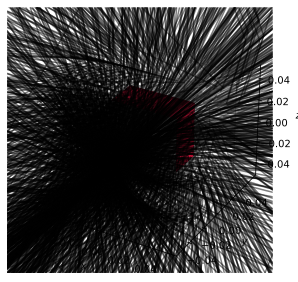

In [11]:
max_dim = max(X_B, Y_B, Z_B)
x, y, z = np.meshgrid(
    np.linspace(-2 * max_dim, 2 * max_dim, 20), 
    np.linspace(-2 * max_dim, 2 * max_dim, 20), 
    np.linspace(-2 * max_dim, 2 * max_dim, 4)
)

u, v, w = MU_0 * np.array(magnetic_field_intensity(x, y, z))

fig = plt.figure()
ax = fig.add_subplot(111, projection=Axes3D.name)

ax.quiver(x, y, z, u, v, w, arrow_length_ratio=0.25, normalize=False, color='black', alpha=0.5)
draw_magnet(ax=ax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
plt.show()

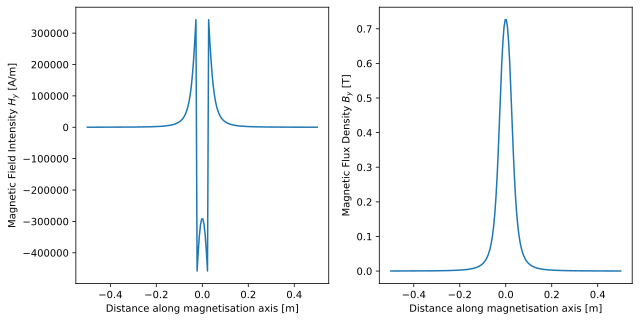

In [12]:
y_pos = np.linspace(-20 * Y_B, 20 * Y_B, 200)
h_vals = np.array(list(map(lambda y: magnetic_field_intensity(0, y, 0)[1], y_pos)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(y_pos, h_vals)
ax1.set_xlabel('Distance along magnetisation axis [m]')
ax1.set_ylabel('Magnetic Field Intensity $H_y$ [A/m]')

m_vals = np.array([M_0 if abs(y) < Y_B else 0 for y in y_pos])
b_vals = MU_0 * (h_vals + m_vals)

ax2.plot(y_pos, b_vals)
ax2.set_xlabel('Distance along magnetisation axis [m]')
ax2.set_ylabel('Magnetic Flux Density $B_y$ [T]')

plt.show()

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

x, y = np.meshgrid(np.linspace(-2 * max_dim, 2 * max_dim, 10), np.linspace(-2 * max_dim, 2 * max_dim, 10))
u, v = magnetic_field_intensity(x, y, 0)[:2]
magnitude = np.hypot(u, v)
stream = ax.streamplot(x, y, u, v,
    color=(MU_0 * magnitude), linewidth=1, cmap=plt.cm.inferno, density=2, arrowstyle='->', arrowsize=1.5)

draw_magnet(ax=ax)  
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_xlim((-2 * max_dim, 2 * max_dim))
ax.set_ylim((-2 * max_dim, 2 * max_dim))
ax.set_aspect('equal')
fig.colorbar(stream.lines, label='Magnetic Flux Density, $|\mathbf{B}|$ [T]')

# save fig as svg
fig.savefig('bar_magnet.svg', format='svg', dpi=1200)
plt.show()